In [1]:
!kaggle datasets download mateuszbuda/lgg-mri-segmentation

'kaggle' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# Brain MRI Tumor Segmentation — Otsu vs Sauvola

import os, glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, filters, color, morphology
from sklearn.metrics import jaccard_score, f1_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Unzip the dataset into lgg-mri-segmentation folder
import zipfile

ZIP_FILE = "lgg-mri-segmentation.zip"
EXTRACT_DIR = "lgg-mri-segmentation"

if not os.path.exists(EXTRACT_DIR):
    with zipfile.ZipFile(ZIP_FILE, 'r') as z:
        z.extractall(EXTRACT_DIR)
    print("Dataset extracted.")
else:
    print("Dataset already extracted.")

Dataset already extracted.


In [4]:
# Load all image-mask pairs and filter to slices that actually contain a tumor
DATA_DIR = os.path.join("lgg-mri-segmentation", "kaggle_3m")

mask_paths = sorted(glob.glob(os.path.join(DATA_DIR, "**", "*_mask.tif"), recursive=True))
image_paths = [p.replace("_mask", "") for p in mask_paths]

# keep only slices where the mask has tumor pixels
tumor_images, tumor_masks = [], []
for img_p, msk_p in zip(image_paths, mask_paths):
    msk = io.imread(msk_p)
    if msk.max() > 0:  # has tumor
        tumor_images.append(img_p)
        tumor_masks.append(msk_p)

print(f"Total slices       : {len(mask_paths)}")
print(f"Slices with tumor  : {len(tumor_images)}")

Total slices       : 3929
Slices with tumor  : 1373


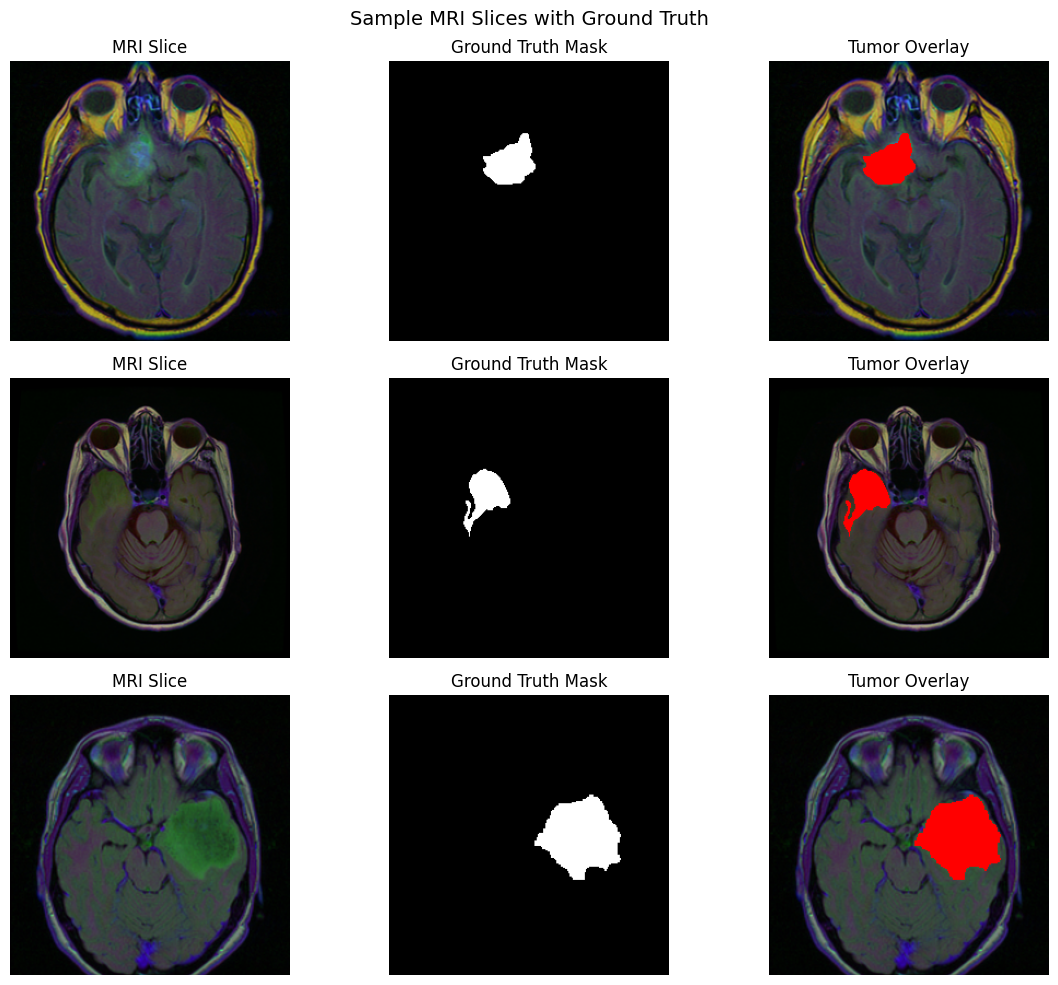

In [5]:
# Visualize a few sample MRI slices with their ground-truth masks
fig, axes = plt.subplots(3, 3, figsize=(12, 10))

for i in range(3):
    idx = i * (len(tumor_images) // 3)  # spread across dataset
    img = io.imread(tumor_images[idx])
    msk = io.imread(tumor_masks[idx])

    axes[i, 0].imshow(img)
    axes[i, 0].set_title("MRI Slice")
    axes[i, 1].imshow(msk, cmap="gray")
    axes[i, 1].set_title("Ground Truth Mask")
    # overlay mask on image
    overlay = img.copy()
    overlay[msk > 0] = [255, 0, 0]
    axes[i, 2].imshow(overlay)
    axes[i, 2].set_title("Tumor Overlay")

for ax in axes.flat:
    ax.axis("off")
plt.suptitle("Sample MRI Slices with Ground Truth", fontsize=14)
plt.tight_layout()
plt.show()

In [6]:
# Dice Score = F1 Score for binary classification
# Jaccard Index = IoU (Intersection over Union)

def dice_score(pred, gt):
    return f1_score(gt.flatten(), pred.flatten(), zero_division=1.0)

def jaccard_index(pred, gt):
    return jaccard_score(gt.flatten(), pred.flatten(), zero_division=1.0)

In [7]:
# --- Segmentation Functions ---

def segment_otsu(gray):
    """Global Otsu thresholding + morphological cleanup"""
    thresh = filters.threshold_otsu(gray)
    binary = gray > thresh
    # clean up small noise
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.binary_closing(binary, morphology.disk(2))
    return binary.astype(np.uint8)

def segment_sauvola(gray, window_size=25, k=0.2):
    """Sauvola adaptive thresholding + morphological cleanup"""
    thresh = filters.threshold_sauvola(gray, window_size=window_size, k=k)
    binary = gray > thresh
    binary = morphology.remove_small_objects(binary, min_size=50)
    binary = morphology.binary_closing(binary, morphology.disk(2))
    return binary.astype(np.uint8)

In [8]:
# Run both methods on ALL tumor slices and collect metrics
otsu_dice_list, otsu_jaccard_list = [], []
sauvola_dice_list, sauvola_jaccard_list = [], []

for img_p, msk_p in zip(tumor_images, tumor_masks):
    img = io.imread(img_p)
    gt = io.imread(msk_p)

    # convert to grayscale
    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img.astype(np.float64) / 255.0

    # binarize ground truth
    gt_bin = (gt > 0).astype(np.uint8)

    # segment
    pred_otsu = segment_otsu(gray)
    pred_sauvola = segment_sauvola(gray)

    # compute metrics
    otsu_dice_list.append(dice_score(pred_otsu, gt_bin))
    otsu_jaccard_list.append(jaccard_index(pred_otsu, gt_bin))
    sauvola_dice_list.append(dice_score(pred_sauvola, gt_bin))
    sauvola_jaccard_list.append(jaccard_index(pred_sauvola, gt_bin))

print(f"Evaluated {len(tumor_images)} tumor slices.")

Evaluated 1373 tumor slices.


In [9]:
# Summary table of results
results = pd.DataFrame({
    "Method": ["Otsu (Global)", "Sauvola (Adaptive)"],
    "Mean Dice": [np.mean(otsu_dice_list), np.mean(sauvola_dice_list)],
    "Std Dice": [np.std(otsu_dice_list), np.std(sauvola_dice_list)],
    "Mean Jaccard": [np.mean(otsu_jaccard_list), np.mean(sauvola_jaccard_list)],
    "Std Jaccard": [np.std(otsu_jaccard_list), np.std(sauvola_jaccard_list)],
})
results

,Method,Mean Dice,Std Dice,Mean Jaccard,Std Jaccard
0,Otsu (Global),0.148507,0.102250,0.083668,0.062769
1,Sauvola (Adaptive),0.076429,0.058608,0.040737,0.032978


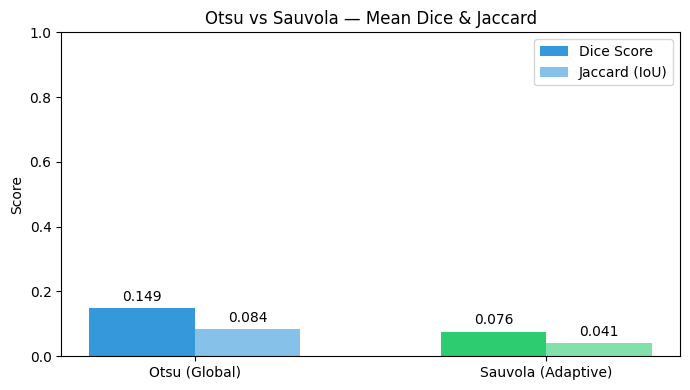

In [10]:
# Bar chart — Mean Dice and Jaccard comparison
fig, ax = plt.subplots(figsize=(7, 4))
x = np.arange(2)
width = 0.3

bars1 = ax.bar(x - width/2, [np.mean(otsu_dice_list), np.mean(sauvola_dice_list)],
               width, label="Dice Score", color=["#3498db", "#2ecc71"])
bars2 = ax.bar(x + width/2, [np.mean(otsu_jaccard_list), np.mean(sauvola_jaccard_list)],
               width, label="Jaccard (IoU)", color=["#85c1e9", "#82e0aa"])

ax.set_ylabel("Score")
ax.set_title("Otsu vs Sauvola — Mean Dice & Jaccard")
ax.set_xticks(x)
ax.set_xticklabels(["Otsu (Global)", "Sauvola (Adaptive)"])
ax.set_ylim(0, 1)
ax.legend()
ax.bar_label(bars1, fmt="%.3f", padding=3)
ax.bar_label(bars2, fmt="%.3f", padding=3)
plt.tight_layout()
plt.show()

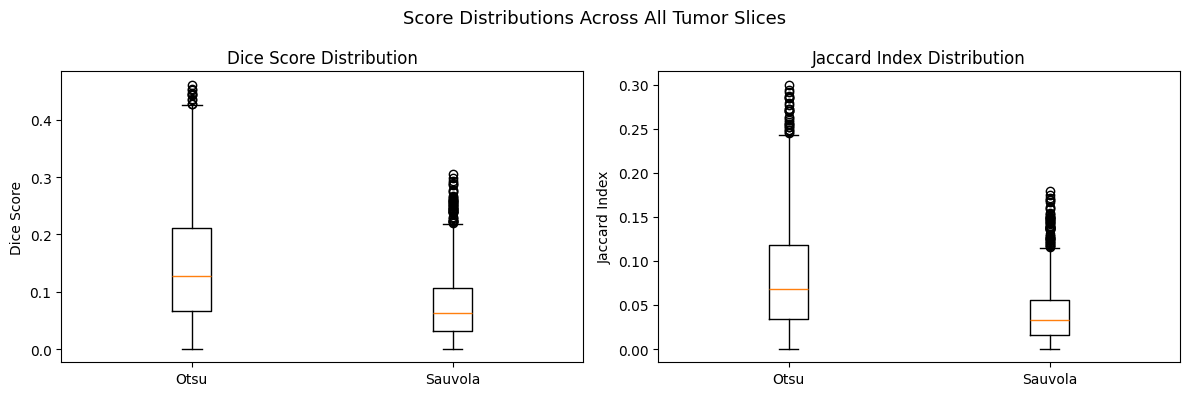

In [11]:
# Box plot — distribution of Dice scores
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

axes[0].boxplot([otsu_dice_list, sauvola_dice_list], labels=["Otsu", "Sauvola"])
axes[0].set_title("Dice Score Distribution")
axes[0].set_ylabel("Dice Score")

axes[1].boxplot([otsu_jaccard_list, sauvola_jaccard_list], labels=["Otsu", "Sauvola"])
axes[1].set_title("Jaccard Index Distribution")
axes[1].set_ylabel("Jaccard Index")

plt.suptitle("Score Distributions Across All Tumor Slices", fontsize=13)
plt.tight_layout()
plt.show()

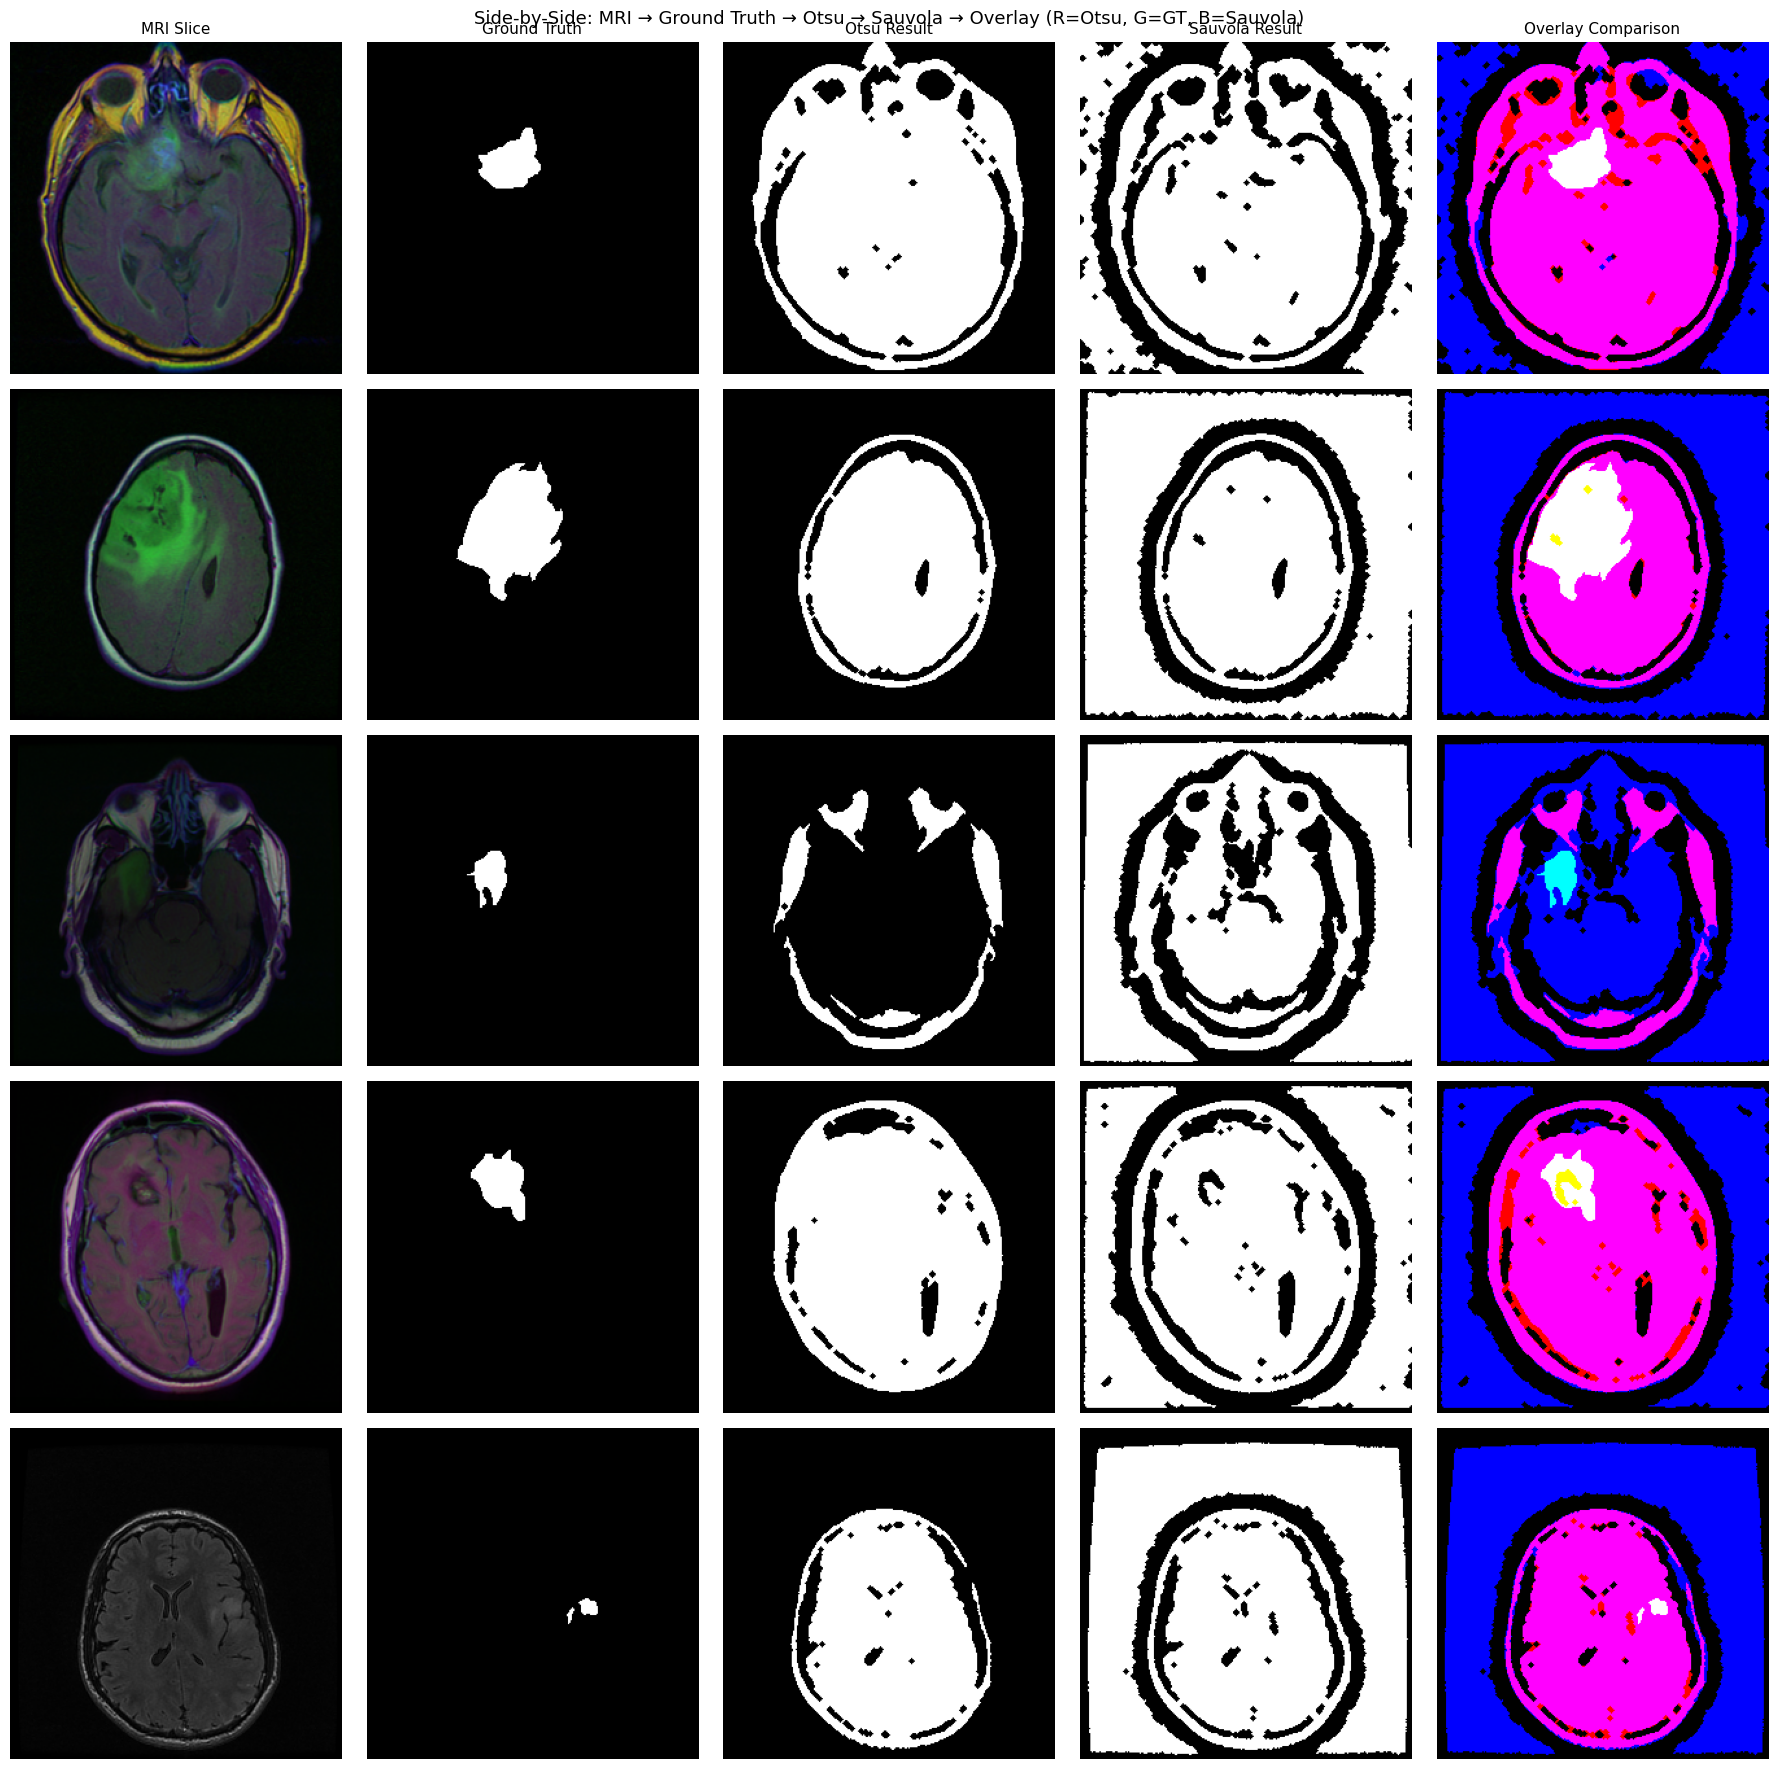

In [12]:
# Visual comparison — pick 5 diverse slices
fig, axes = plt.subplots(5, 5, figsize=(18, 18))
col_titles = ["MRI Slice", "Ground Truth", "Otsu Result", "Sauvola Result", "Overlay Comparison"]

# pick 5 evenly spaced indices
indices = np.linspace(0, len(tumor_images) - 1, 5, dtype=int)

for row, idx in enumerate(indices):
    img = io.imread(tumor_images[idx])
    gt = io.imread(tumor_masks[idx])
    gt_bin = (gt > 0).astype(np.uint8)

    if img.ndim == 3:
        gray = color.rgb2gray(img)
    else:
        gray = img.astype(np.float64) / 255.0

    pred_otsu = segment_otsu(gray)
    pred_sauvola = segment_sauvola(gray)

    # original
    axes[row, 0].imshow(img)
    # ground truth
    axes[row, 1].imshow(gt_bin, cmap="gray")
    # otsu
    axes[row, 2].imshow(pred_otsu, cmap="gray")
    # sauvola
    axes[row, 3].imshow(pred_sauvola, cmap="gray")
    # overlay: green=GT, red=Otsu, blue=Sauvola
    overlay = np.zeros((*gt_bin.shape, 3), dtype=np.uint8)
    overlay[..., 1] = gt_bin * 255       # green = ground truth
    overlay[..., 0] = pred_otsu * 255     # red = Otsu
    overlay[..., 2] = pred_sauvola * 255  # blue = Sauvola
    axes[row, 4].imshow(overlay)

    # row labels with scores
    d_o = dice_score(pred_otsu, gt_bin)
    d_s = dice_score(pred_sauvola, gt_bin)
    axes[row, 0].set_ylabel(f"Dice: O={d_o:.2f} S={d_s:.2f}", fontsize=10)

for j, t in enumerate(col_titles):
    axes[0, j].set_title(t, fontsize=11)
for ax in axes.flat:
    ax.axis("off")

plt.suptitle("Side-by-Side: MRI → Ground Truth → Otsu → Sauvola → Overlay (R=Otsu, G=GT, B=Sauvola)", fontsize=13)
plt.tight_layout()
plt.show()

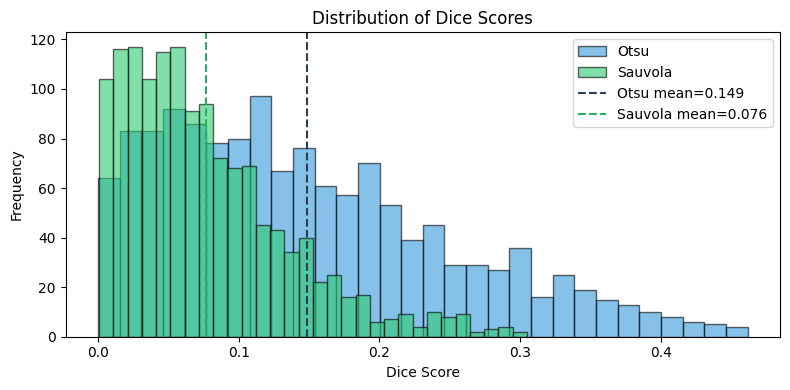

In [13]:
# Histogram of Dice scores for both methods
fig, ax = plt.subplots(figsize=(8, 4))
ax.hist(otsu_dice_list, bins=30, alpha=0.6, label="Otsu", color="#3498db", edgecolor="black")
ax.hist(sauvola_dice_list, bins=30, alpha=0.6, label="Sauvola", color="#2ecc71", edgecolor="black")
ax.axvline(np.mean(otsu_dice_list), color="#2c3e50", linestyle="--", label=f"Otsu mean={np.mean(otsu_dice_list):.3f}")
ax.axvline(np.mean(sauvola_dice_list), color="#27ae60", linestyle="--", label=f"Sauvola mean={np.mean(sauvola_dice_list):.3f}")
ax.set_xlabel("Dice Score")
ax.set_ylabel("Frequency")
ax.set_title("Distribution of Dice Scores")
ax.legend()
plt.tight_layout()
plt.show()

In [54]:
# Conclusion
print("CONCLUSION: Otsu vs Sauvola for Brain MRI Tumor Segmentation")
print()
print(f"  Otsu  (Global)   — Dice: {np.mean(otsu_dice_list):.4f} ± {np.std(otsu_dice_list):.4f}  |  Jaccard: {np.mean(otsu_jaccard_list):.4f} ± {np.std(otsu_jaccard_list):.4f}")
print(f"  Sauvola (Adaptive) — Dice: {np.mean(sauvola_dice_list):.4f} ± {np.std(sauvola_dice_list):.4f}  |  Jaccard: {np.mean(sauvola_jaccard_list):.4f} ± {np.std(sauvola_jaccard_list):.4f}")
print()
print("Key Takeaways:")
print("  - Otsu uses a single global threshold computed from the image histogram.")
print("    It works well when tumor and background have distinct intensity peaks.")
print("  - Sauvola adapts the threshold locally using mean and std in a window.")
print("    It captures local contrast variations but may over-segment noisy regions.")
print("  - Neither method is designed for tumor segmentation specifically, as both score low.")


CONCLUSION: Otsu vs Sauvola for Brain MRI Tumor Segmentation

  Otsu  (Global)   — Dice: 0.1478 ± 0.1010  |  Jaccard: 0.0832 ± 0.0617
  Sauvola (Adaptive) — Dice: 0.0770 ± 0.0580  |  Jaccard: 0.0410 ± 0.0326

Key Takeaways:
  - Otsu uses a single global threshold computed from the image histogram.
    It works well when tumor and background have distinct intensity peaks.
  - Sauvola adapts the threshold locally using mean and std in a window.
    It captures local contrast variations but may over-segment noisy regions.
  - Neither method is designed for tumor segmentation specifically, as both score low.
